Import all requirements and helper functions


In [1]:
# Turning ML Paper into usable code:
# Specifically "An Image Is Worth 16x16 Words"
# https://arxiv.org/abs/2010.11929

#Importing all torch libraries
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions are not installed")



torch version: 2.2.2+cu118
torchvision version: 0.17.2+cu118


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\A-Man\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Import Dataset and create paths to train and test data

In [4]:
# Get the Food Vision Mini Dataset
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Create Dataloaders for train and test data

In [6]:
#Create Datasets and Dataloaders
from torchvision import transforms
from going_modular.going_modular import data_setup
IMG_SIZE = 224 # table 3

#transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print(f"manual transforms: {manual_transforms}")

manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#create batch size, starting small
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
) 

In [8]:
len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [9]:
#single image visualization
import random 
import numpy as np
import matplotlib.pyplot as plt

img_batch, label_batch = next(iter(train_dataloader))
img,label = img_batch[0],label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

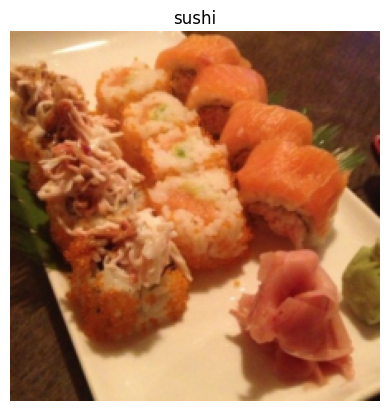

In [10]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

Recreating The Vision Transformer



### 3.1 ViT overview: pieces of the puzzle
* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text
#### Figure 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)
* Embedding = learnable representation (random numbers -> imrpovement over time)
* MLP = Multi Layer Perceptron
#### Four equations
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)
#### Table 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2, C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

In [11]:
#Recreating The Vision Transformer Architecture
'''
Eq.1 in Pseudocode

x_input = [class_token, img_patch_1, img_patch_2,...,img_patch_N] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos,...,image_patch_N_pos]

Eq.2 in Pseudocode = MSA (Multihead Self Attention) block
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

Eq.3 in Pseudocode = MLP (Multi Layer Perseptron) block
x_output_MLP_block = MLP_Layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

Eq.4 in Pseudocode:
y_output = linear_layer(LN_layer(x_output_MLP_block))

''' 

'\nEq.1 in Pseudocode\n\nx_input = [class_token, img_patch_1, img_patch_2,...,img_patch_N] +\n[class_token_pos, image_patch_1_pos, image_patch_2_pos,...,image_patch_N_pos]\n\nEq.2 in Pseudocode = MSA (Multihead Self Attention) block\nx_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input\n\nEq.3 in Pseudocode = MLP (Multi Layer Perseptron) block\nx_output_MLP_block = MLP_Layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block\n\nEq.4 in Pseudocode:\ny_output = linear_layer(LN_layer(x_output_MLP_block))\n\n'

In [12]:
# Equation 1: Split data into patches, creating the class, pos, and patch embeddings
#input shape: (224,224,3) - single img H * W * C

#H = height
#W = width
#C = color channels
#N = Number patches // N = H*W/P^2 
#P = patch size
#D = constant latent vec size = embedding dim (See Table 1)

#output shape: N * (P^2 * C)
height = 224
width = 224
color = 3
patch_size = 16
N = int((height*width)/(patch_size**2))
print(f"Number Patches: {N}")
output_shape = int(N * (patch_size**2 * color))
print(f"Output Shape: {output_shape}")

Number Patches: 196
Output Shape: 150528


In [13]:
#input shape
embedding_layer_input_shape = (height,width,color)
#output shape
embedding_layer_output_shape = (N,patch_size**2 * color)
print(f"Input Shape (2D image): {embedding_layer_input_shape}")
print(f"Output Shape (1D sequence of patches): {embedding_layer_output_shape}") #number_patches,embedding_dimension



Input Shape (2D image): (224, 224, 3)
Output Shape (1D sequence of patches): (196, 768)


(-0.5, 223.5, 223.5, -0.5)

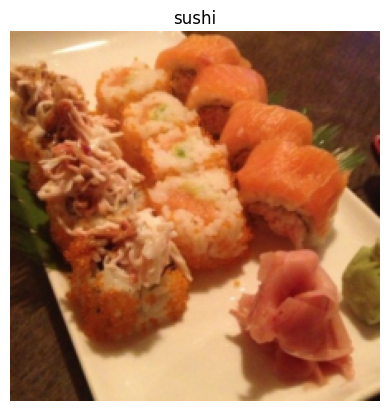

In [14]:
#Turning a single image into patches
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [15]:
img.shape

torch.Size([3, 224, 224])

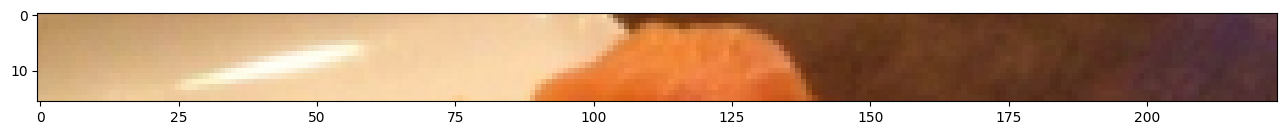

In [16]:
#Get the top row
image_permuted = img.permute(1,2,0)#HWC

patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Text(0.5, 0.98, 'sushi -> Patchified')

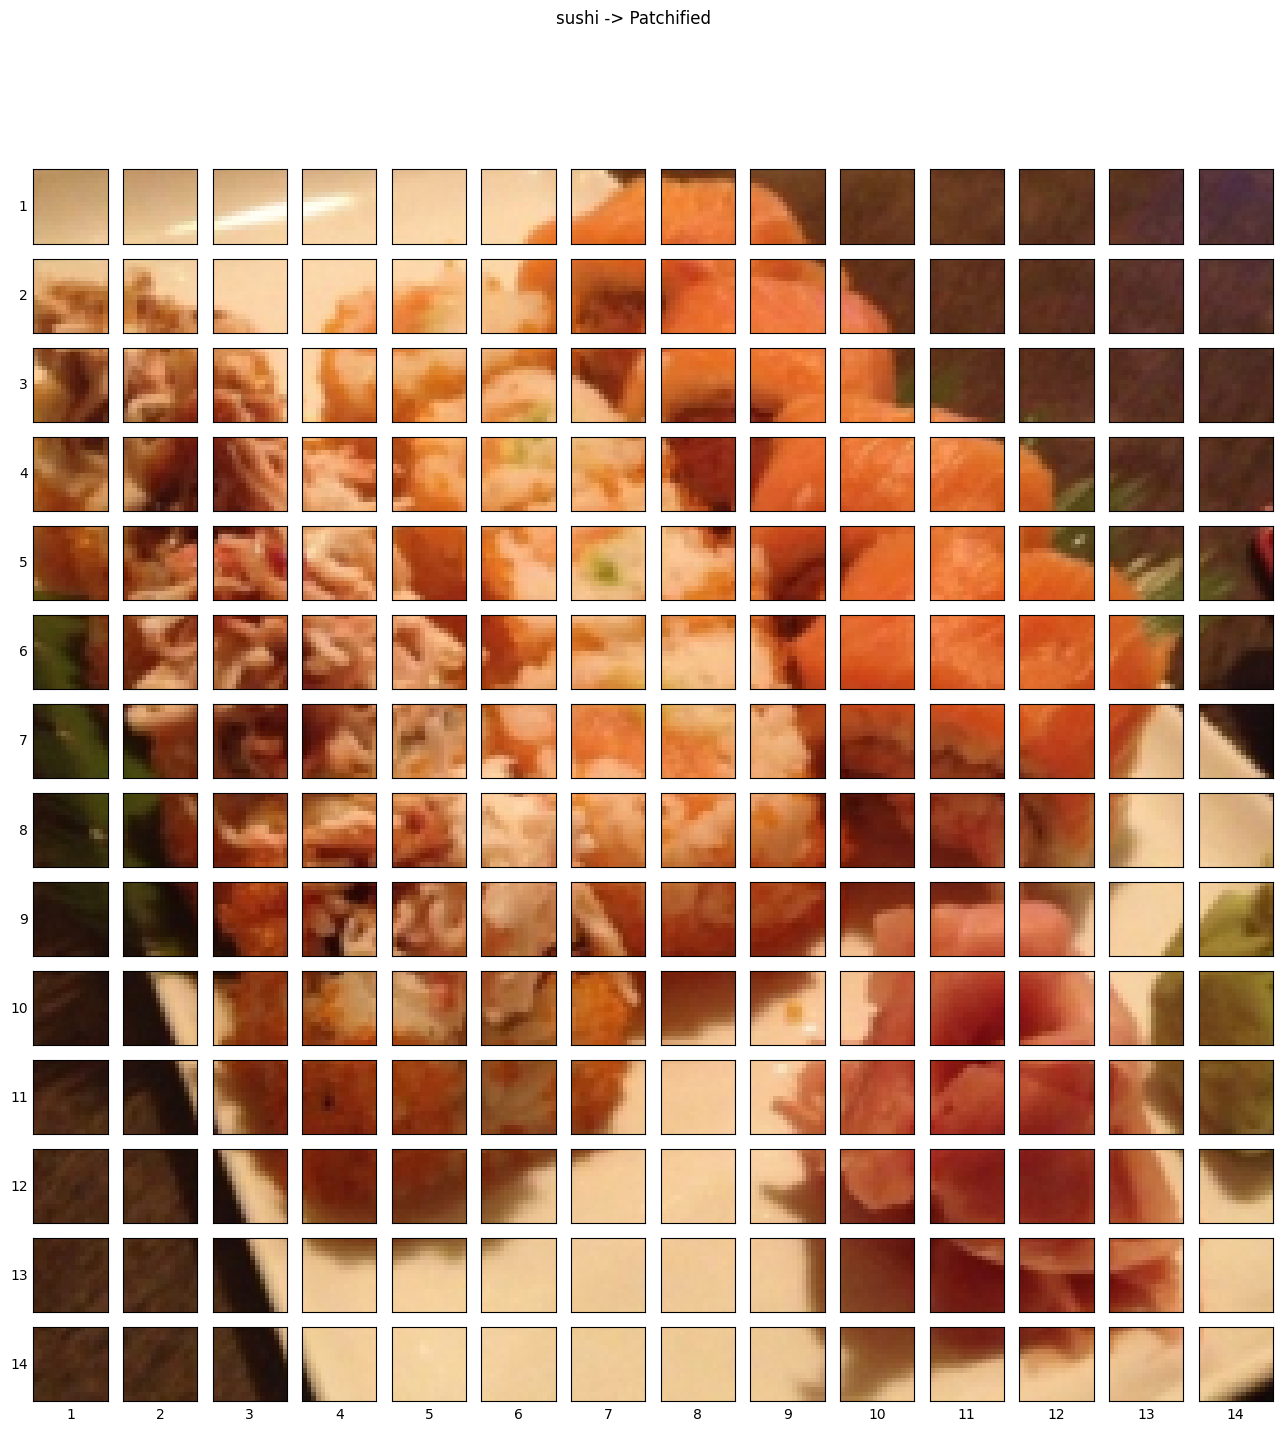

In [17]:
#Plot top row as a row of patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
num_patches
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

#Create a series of subplots
fig,ax = plt.subplots(nrows=img_size // patch_size,
                      ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size,patch_size))

#loop through H and W
for i,patch_height in enumerate(range(0,img_size,patch_size)): #height
    for j,patch_width in enumerate(range(0,img_size,patch_size)): #width
        #plotting image on different axes
        ax[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                      patch_width:patch_width+patch_size,:])
        ax[i,j].set_ylabel(i+1,rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
        ax[i,j].set_xlabel(j+1)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified")

In [18]:
#flatten image into 1d and embeddings using torch nn conv2d
from torch import nn
patch_size = 16
conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels=768, #size from Table 1
                   kernel_size=patch_size,
                   stride= patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

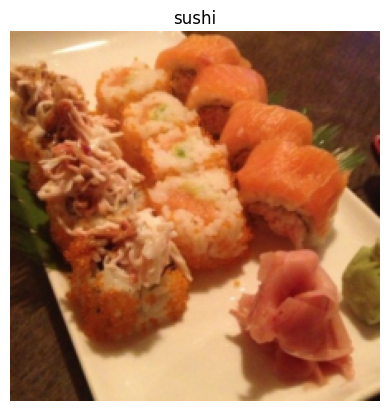

In [19]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [20]:
#pass img through conv2d
img_conv2d = conv2d(img.unsqueeze(0))# adding batch dimension
print(img_conv2d.shape)

torch.Size([1, 768, 14, 14])


Showing random conv feature maps from indexes: [422, 290, 360, 378, 145]


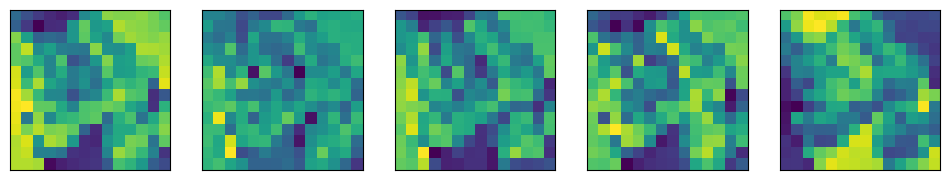

In [24]:
#image is now in the correct representation that the paper needs
# now we flatten the embeddings into a sequence
torch.Size([1,768,14,14])#[batch_size,embedding_dim,feature_map_height,feature_map_width]
import random
rand_idxs = random.sample(range(0,758),k=5)
print(f"Showing random conv feature maps from indexes: {rand_idxs}")

#create plot
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i, idx in enumerate(rand_idxs):
    image_conv_feature_map = img_conv2d[:,idx,:,:]# index on the output tensor of c2d layer
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    ax[i].set(xticklabels=[],yticklabels=[], xticks=[], yticks=[])


In [25]:
#Get a single feature map in tensor form
single_feature_map = img_conv2d[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[ 2.9490e-01,  3.3643e-01,  4.1710e-01,  5.0740e-01,  3.8505e-01,
            3.6827e-01,  4.0876e-01,  2.8869e-01,  2.4295e-01,  7.0754e-02,
            1.0957e-01,  1.0283e-01,  1.0910e-01,  1.1278e-01],
          [ 1.2180e-01,  1.1723e-02,  3.7624e-01,  3.5815e-01,  1.7774e-01,
            3.9591e-01,  5.6179e-02,  7.9025e-02,  2.4491e-01,  1.0113e-01,
            9.5156e-02,  8.6747e-02,  8.7503e-02,  1.1208e-01],
          [ 6.5822e-02,  1.9175e-01, -8.7105e-03,  1.9929e-01,  1.5085e-01,
            2.8003e-01,  9.1269e-02,  1.5432e-01,  1.4345e-01,  2.9036e-01,
            3.6209e-02,  7.8930e-02,  9.3671e-02,  1.0083e-01],
          [ 1.5412e-01,  1.4181e-01,  1.5878e-02,  4.8125e-01,  4.2874e-02,
            1.9327e-01,  2.3023e-01,  3.3579e-02,  1.5238e-01,  1.1855e-01,
            1.8545e-01,  1.4756e-01,  7.4071e-02,  9.4668e-02],
          [ 8.3985e-02,  9.8948e-02,  2.3261e-01,  2.5286e-01,  9.4313e-02,
            2.1958e-01,  1.6238e-01,  4.6476e-01,  1.2301e-0

In [41]:
#Time to flatten the feature map
from torch import nn
print(img_conv2d.shape)
#img_conv2d_flat = torch.flatten(img_conv2d,2,3)
flatten = nn.Flatten(start_dim=2,end_dim=3)
flatten(img_conv2d).shape



torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 196])

Original Image Shape: torch.Size([3, 224, 224])
Feature Map: torch.Size([1, 768, 14, 14])
Flattened Feature Map Shape: torch.Size([1, 768, 196])
Permuted Shape: torch.Size([1, 196, 768])


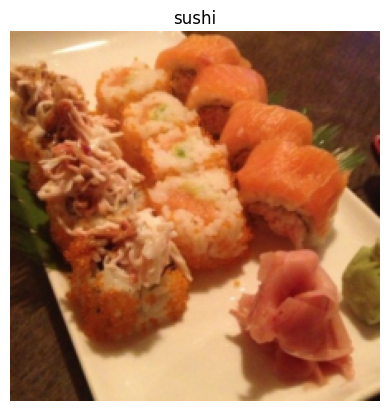

In [51]:
#Put everything together
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original Image Shape: {img.shape}")

#Turn into Feature Maps
image_out_of_conv = conv2d(img.unsqueeze(0))#add batch dim
print(f"Feature Map: {image_out_of_conv.shape}")

#Flatten
img_out_conv_flat = flatten(image_out_of_conv)
print(f"Flattened Feature Map Shape: {img_out_conv_flat.shape}")
print(f"Permuted Shape: {img_out_conv_flat.permute(0,2,1).shape}")#batch_size, num_patches,embed_dim 